# HSCT survival: Voting classifier

## Notebook set-up

In [1]:
import pickle
from warnings import simplefilter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

import configuration as config
import functions.helper as helper_funcs

dataset='Binary target encoded, power transformed'
notebook_num='04.8'
simplefilter('ignore', category=ConvergenceWarning)

# Data files
datasets_file=f'{config.PROCESSED_DATA}/01.2-dataset_definitions.pkl'
coxph_survival_file=f'{config.PROCESSED_DATA}/02.1-coxPH_survival.pkl'
weibullaft_survival_file=f'{config.PROCESSED_DATA}/02.2-weibullAFT_survival.pkl'
kld_features_file=f'{config.PROCESSED_DATA}/02.3-kld_survival.pkl'
model_optimization_results_file=f'{config.RESULTS}/sklearn_classifier_test.pkl'

# Model files
tuned_model_file=f'{config.MODELS_PATH}/{notebook_num}-voting_EFS_classifier.pkl'

# Experiment results
hyperparameter_tuning_results=f'{config.DATA_PATH}/results/data/{notebook_num}-hyperparameter_tuning_results.csv'
training_scores_file=f'{config.DATA_PATH}/results/data/{notebook_num}-training_scores.csv'
testing_scores_file=f'{config.DATA_PATH}/results/data/{notebook_num}-testing_scores.csv'

retune_model=True

## 1. Load data

In [2]:
# Read the dataset metadata
with open(datasets_file, 'rb') as input_file:
    datasets=pickle.load(input_file)

# Load one of the datasets
with open(datasets[dataset], 'rb') as input_file:
    data_dict=pickle.load(input_file)

print('Data dictionary contains:\n')
for key, value in data_dict.items():
    print(f' {key}: {type(value)}')

# Load Cox Proportional Hazard model features
with open(coxph_survival_file, 'rb') as input_file:
    coxph_features=pickle.load(input_file)

print('\nCox PH features:\n')
for key, value in coxph_features.items():
    print(f' {key}: {type(value)}')

# Load Weibull Accelerated Failure Time model features
with open(weibullaft_survival_file, 'rb') as input_file:
    weibullaft_features=pickle.load(input_file)

print('\nWeibull AFT features:\n')
for key, value in weibullaft_features.items():
    print(f' {key}: {type(value)}')

# Load KLD features
with open(kld_features_file, 'rb') as input_file:
    kld_features=pickle.load(input_file)

print('\nKLD features:\n')
for key, value in kld_features.items():
    print(f' {key}: {type(value)}')

# Load model hyperparameter tuning results
with open(model_optimization_results_file, 'rb') as input_file:
    model_hyperparameters=pickle.load(input_file)

print('\nModel hyperparameters:\n')
for key, value in model_hyperparameters.items():
    print(f' {key}: {type(value)}')

Data dictionary contains:

 Training features: <class 'pandas.core.frame.DataFrame'>
 Training labels: <class 'pandas.core.frame.DataFrame'>
 Training IDs: <class 'list'>
 Training race group: <class 'list'>
 Testing features: <class 'pandas.core.frame.DataFrame'>
 Testing labels: <class 'pandas.core.frame.DataFrame'>
 Testing IDs: <class 'list'>
 Testing race group: <class 'list'>

Cox PH features:

 Training survival: <class 'list'>
 Training partial hazard: <class 'list'>
 Testing survival: <class 'list'>
 Testing partial hazard: <class 'list'>

Weibull AFT features:

 Training survival: <class 'list'>
 Training expectation: <class 'list'>
 Testing survival: <class 'list'>
 Testing expectation: <class 'list'>

KLD features:

 Training CoxPH survival KLD: <class 'numpy.ndarray'>
 Training CoxPH partial hazard KLD: <class 'numpy.ndarray'>
 Training WeibullAFT survival KLD: <class 'numpy.ndarray'>
 Training WeibullAFT expectation KLD: <class 'numpy.ndarray'>
 Testing CoxPH survival KLD

## 2. Data preparation

### 2.1. Add survival model features

In [3]:
training_features_df=data_dict['Training features']
training_features_df['CoxPH survival']=coxph_features['Training survival']
training_features_df['CoxPH partial hazard']=coxph_features['Training partial hazard']
training_features_df['WeibullAFT survival']=weibullaft_features['Training survival']
training_features_df['WeibullAFT expectation']=weibullaft_features['Training expectation']

testing_features_df=data_dict['Testing features']
testing_features_df['CoxPH survival']=coxph_features['Testing survival']
testing_features_df['CoxPH partial hazard']=coxph_features['Testing partial hazard']
testing_features_df['WeibullAFT survival']=weibullaft_features['Testing survival']
testing_features_df['WeibullAFT expectation']=weibullaft_features['Testing expectation']

training_features_df.head().transpose()

,0,1,2,3,4
psych_disturb,-2.949030e-17,-2.949030e-17,-2.949030e-17,-2.949030e-17,1.040834e-16
diabetes,1.578598e-16,-4.163336e-17,-4.163336e-17,1.578598e-16,7.285839e-17
tbi_status,4.417244e-01,4.417244e-01,4.417244e-01,-1.025746e-01,-1.025746e-01
arrhythmia,-1.734723e-18,-1.734723e-18,-1.734723e-18,-1.734723e-18,1.387779e-17
graft_type,6.351465e-01,6.351465e-01,-1.574440e+00,6.351465e-01,-1.574440e+00
...,...,...,...,...,...
age_at_hct,3.234649e-01,1.303733e-01,-1.600331e-01,6.554360e-01,8.109253e-01
CoxPH survival,4.056278e-01,5.268635e-01,6.044865e-01,2.012533e-01,2.634279e-01
CoxPH partial hazard,1.185550e+00,8.419601e-01,6.613816e-01,2.106420e+00,1.752700e+00
WeibullAFT survival,1.780691e-01,2.831991e-01,3.711367e-01,5.227801e-02,7.820002e-02


### 2.3. Add KLD features

In [4]:
training_features_df['CoxPH survival KLD']=kld_features['Training CoxPH survival KLD']
training_features_df['CoxPH partial hazard KLD']=kld_features['Training CoxPH partial hazard KLD']
training_features_df['WeibullAFT survival KLD']=kld_features['Training WeibullAFT survival KLD']
training_features_df['WeibullAFT expectation KLD']=kld_features['Training WeibullAFT expectation KLD']
testing_features_df['CoxPH survival KLD']=kld_features['Testing CoxPH survival KLD']
testing_features_df['CoxPH partial hazard KLD']=kld_features['Testing CoxPH partial hazard KLD']
testing_features_df['WeibullAFT survival KLD']=kld_features['Testing WeibullAFT survival KLD']
testing_features_df['WeibullAFT expectation KLD']=kld_features['Testing WeibullAFT expectation KLD']

### 2.4. Standard scale features

In [5]:
scaler=StandardScaler()
scaler.fit(training_features_df)
training_features_df=scaler.fit_transform(training_features_df)
testing_features_df=scaler.fit_transform(testing_features_df)

### 2.3. Load labels, race group and ID

In [6]:
training_labels_df=data_dict['Training labels']
training_labels_df['efs_time']=np.log(training_labels_df['efs_time'])
training_race_groups=data_dict['Training race group']
training_ids=data_dict['Training IDs']

testing_labels_df=data_dict['Testing labels']
testing_labels_df['efs_time']=np.log(testing_labels_df['efs_time'])
testing_race_groups=data_dict['Testing race group']
testing_ids=data_dict['Testing IDs']

## 3. Voting classifier

### 3.1. Model calibration

In [ ]:
models={
    'RBF SVM':SVC(kernel='rbf', class_weight='balanced'),
    'Random Forest':RandomForestClassifier(class_weight='balanced', n_jobs=1),
    'AdaBoost':AdaBoostClassifier(),
    'CatBoost':CatBoostClassifier(thread_count=1, verbose=0),
    'XGBoost':XGBClassifier(n_jobs=1)
}

for model_name, model in models.items():
    print(f'Calibrating {model_name}')
    hyperparameters=model_hyperparameters[model_name]
    model.set_params(**hyperparameters)
    calibrated_model=CalibratedClassifierCV(model, cv=3, n_jobs=-1)
    calibrated_model.fit(training_features_df, training_labels_df['efs'])
    models[model_name]=calibrated_model

Calibrating RBF SVM


/mnt/arkk/kaggle/HSCT_survival/.venv/lib/python3.10/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/mnt/arkk/kaggle/HSCT_survival/.venv/lib/python3.10/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/mnt/arkk/kaggle/HSCT_survival/.venv/lib/python3.10/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Calibrating Random Forest
Calibrating AdaBoost
Calibrating CatBoost
Calibrating XGBoost


/mnt/arkk/kaggle/HSCT_survival/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:12:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose_eval" } are not used.

  warnings.warn(smsg, UserWarning)
/mnt/arkk/kaggle/HSCT_survival/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:12:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose_eval" } are not used.

  warnings.warn(smsg, UserWarning)
/mnt/arkk/kaggle/HSCT_survival/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:12:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose_eval" } are not used.

  warnings.warn(smsg, UserWarning)


### 3.2. Cross-validation

In [8]:
calibrated_classifiers=list(zip(list(models.keys()), list(models.values())))

ensemble_model=VotingClassifier(
    estimators=calibrated_classifiers,
    voting='soft',
    n_jobs=-1
)

scores=cross_val_score(
    ensemble_model,
    training_features_df,
    training_labels_df['efs'],
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

print(f'Cross-validation accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')

[00:12:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose_eval" } are not used.

[00:12:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose_eval" } are not used.

[00:12:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose_eval" } are not used.

[00:12:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose_eval" } are not used.

[00:12:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose_eval" } are not used.

[00:12:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose_eval" } are not used.

[00:12:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose_eval" } are not used.

[00:12:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose_eval" } are not used.

[00:12:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose_eval" } are not used.

[00:12:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose_eval" } are not used.

[00:12:46] WARNING: 

Cross-validation accuracy: 0.684 +/- 0.005


### 3.3. Test set performance

In [9]:
ensemble_model=VotingClassifier(
    estimators=calibrated_classifiers,
    voting='soft',
    n_jobs=-1
)

calibrated_model=CalibratedClassifierCV(ensemble_model, cv=3, n_jobs=-1)
calibrated_model.fit(training_features_df, training_labels_df['efs'])

predictions=calibrated_model.predict(testing_features_df)

[00:15:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose_eval" } are not used.

[00:15:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose_eval" } are not used.

[00:15:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose_eval" } are not used.

[00:15:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose_eval" } are not used.

[00:15:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose_eval" } are not used.

[00:15:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose_eval" } are not used.

[00:15:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose_eval" } are not used.

[00:15:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose_eval" } are not used.

[00:15:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose_eval" } are not used.



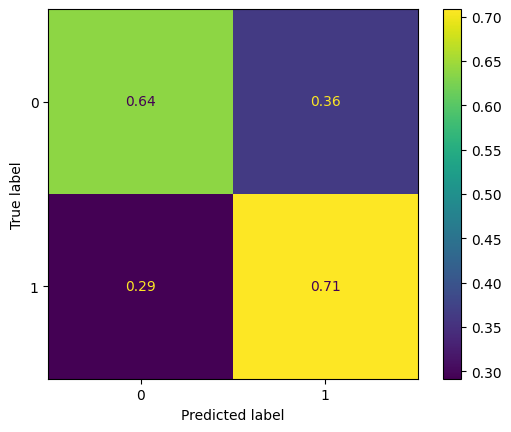

In [10]:
cm=confusion_matrix(testing_labels_df['efs'], predictions, normalize='true')
cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm)
_=cm_disp.plot()